In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
df = pd.read_csv("states.csv")
import matplotlib.pyplot as plt

In [2]:
!python -V

Python 3.9.6


In [3]:
iforest = IsolationForest(n_estimators=100).fit(df.iloc[:,1:])

In [4]:
iforestScores = iforest.score_samples(df.iloc[:,1:])

In [5]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [6]:
a = df.columns


In [7]:
import statsmodels.api as sm


In [8]:
df2 = pd.concat([pd.DataFrame(iforestScores),df],axis=1)

df2.columns = a.insert(0,"Anomaly")

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import numpy as np

regr = DecisionTreeRegressor(max_depth=5, random_state=1234)
X = df2[a[1:]]
model = regr.fit(df2[a[1:]], abs(df2['Anomaly']))

# Print rules
rules = get_rules(regr, df2.columns, None)

In [10]:
rules

['if (Poverty > 65.1) and (White <= 386.15) and (Traf Deaths <= 6.6) and (Anomaly <= 14.75) and (University <= 52099.0) then response: 0.414 | based on 17 samples',
 'if (Poverty > 65.1) and (White <= 386.15) and (Traf Deaths <= 6.6) and (Anomaly <= 14.75) and (University > 52099.0) then response: 0.45 | based on 12 samples',
 'if (Poverty > 65.1) and (White <= 386.15) and (Traf Deaths <= 6.6) and (Anomaly > 14.75) and (Infant Mort > 281.5) then response: 0.466 | based on 8 samples',
 'if (Poverty > 65.1) and (White <= 386.15) and (Traf Deaths > 6.6) and (States > 5.55) and (Unemployed <= 7234102.0) then response: 0.489 | based on 4 samples',
 'if (Poverty > 65.1) and (White > 386.15) and (States > 5.2) then response: 0.516 | based on 1 samples',
 'if (Poverty > 65.1) and (White > 386.15) and (States <= 5.2) then response: 0.579 | based on 1 samples',
 'if (Poverty > 65.1) and (White <= 386.15) and (Traf Deaths > 6.6) and (States > 5.55) and (Unemployed > 7234102.0) then response: 0.44

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


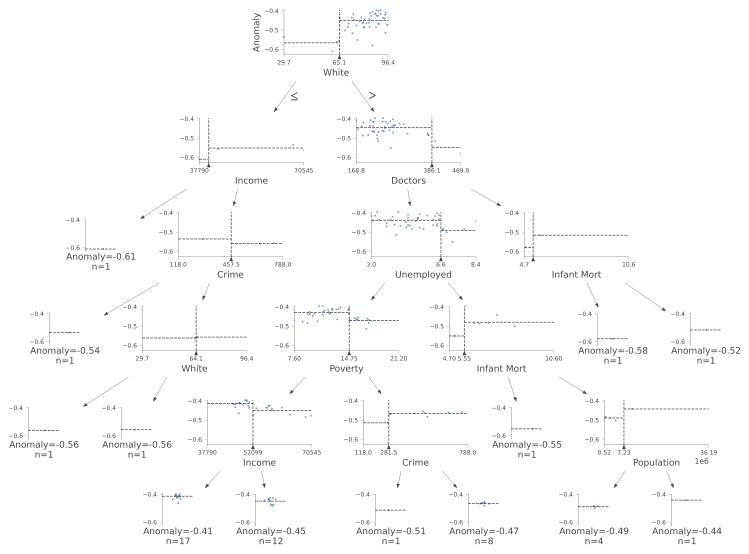

In [11]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model, X, df2['Anomaly'],
                target_name="Anomaly",
                feature_names=X.columns
              )

viz

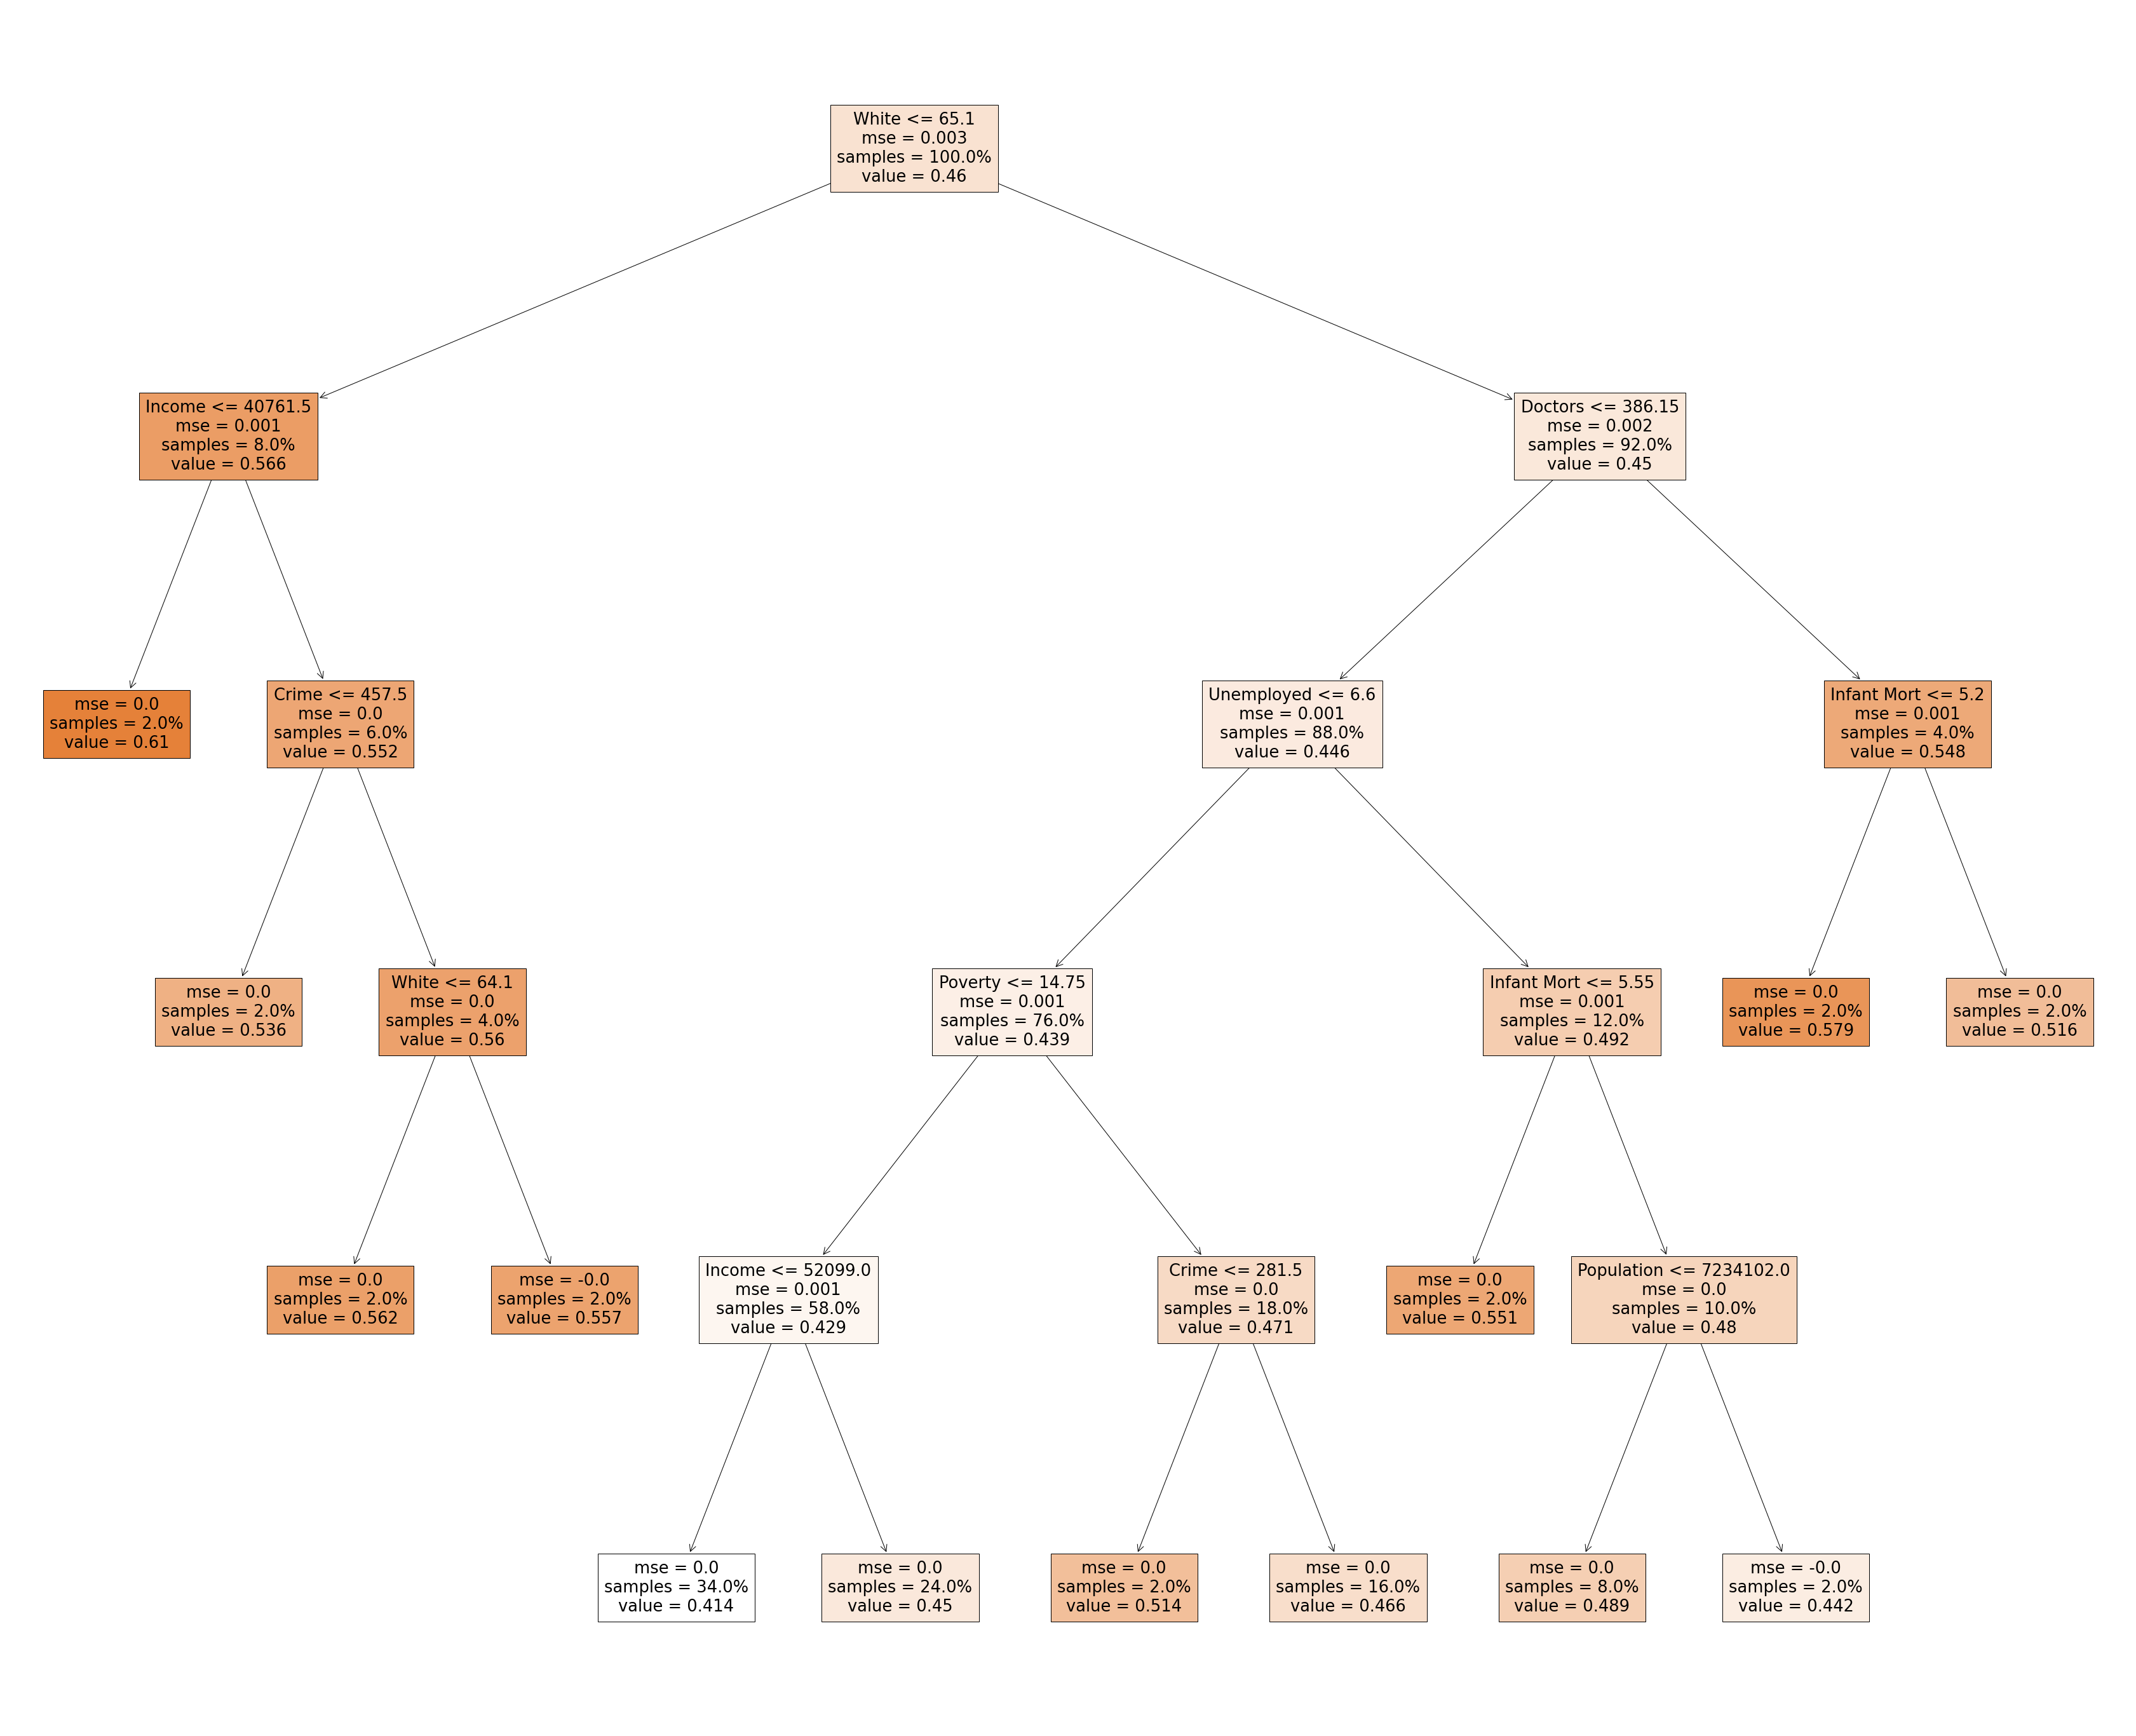

In [12]:
fig = plt.figure(figsize=(60,50))
_ = tree.plot_tree(regr, 
                   feature_names=a[1:],  
                   proportion = True,
                   #class_names=df2['States'],
                   #label=all,
                   filled=True)

In [42]:
#df2[a[1:]]
standardDevs = ((df2[a[1:]]-df2[a[1:]].describe().loc['mean'])/df2[a[1:]].describe().loc['std'])
mdist = pd.DataFrame(((df2[a[1:]]-df2[a[1:]].describe().loc['mean'])/df2[a[1:]].describe().loc['std']).mean(axis=1),columns=['mdist'])

In [19]:
from zca import zca
import numpy as np

N = 100
K= 4

data = np.random.rand(N, K)

zca = zca.ZCA()

# Separate fit and transform
zca.fit(standardDevs)

data_zca = zca.transform(standardDevs)

data_zca = zca.fit_transform(standardDevs)

In [43]:
zcaS = pd.DataFrame(pd.DataFrame(data_zca,columns=standardDevs.columns).mean(axis=1),columns=['ZCAs'])

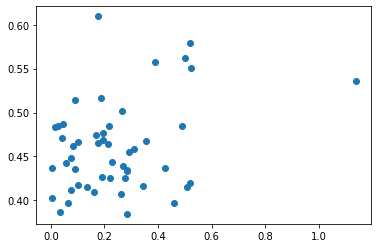

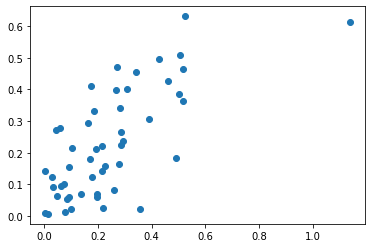

In [50]:
combined = pd.concat([mdist,zcaS,df2],axis=1)

plt.scatter(abs(combined['ZCAs']),abs(combined['Anomaly']))

plt.show()

plt.scatter(abs(combined['ZCAs']),abs(combined['mdist']))

plt.show()

In [61]:
display(combined.sort_values(kind="quicksort", ascending=True, by='mdist',key=abs))
display(combined.sort_values(kind="quicksort", ascending=True, by='ZCAs',key=abs))
display(combined.sort_values(kind="quicksort", ascending=True, by='Anomaly',key=abs))

,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
3,0.006573,0.014987,-0.483398,Arkansas,17.3,8.5,80.8,529,203.4,1.96,18.8,5.1,38815,2841595
36,-0.010186,-0.003048,-0.402661,Oregon,13.6,5.5,90.1,288,274.5,1.31,28.1,6.4,50169,3730833
7,0.013334,-0.075864,-0.447911,Delaware,10.0,8.3,74.3,689,250.9,1.23,27.5,4.8,57989,865314
0,-0.021329,-0.099447,-0.466184,Alabama,15.7,9.0,71.0,448,218.2,1.81,22.0,5.0,42666,4634063
25,-0.022396,0.356068,-0.467990,Montana,14.8,5.8,90.5,288,220.6,2.45,27.1,4.5,43654,957123
5,0.026178,0.219403,-0.425532,Colorado,11.4,5.7,89.7,348,259.7,1.14,35.6,4.9,56993,4837229
30,-0.054239,-0.083534,-0.461819,New Mexico,17.1,5.8,84.0,664,243.6,1.54,24.7,4.2,43508,1966357
16,0.059423,0.195246,-0.468364,Kentucky,17.3,7.5,89.9,295,232.3,1.80,19.7,6.4,41538,4254513
45,-0.059860,0.090363,-0.435581,Virginia,10.2,7.1,73.0,270,274.5,1.25,33.7,4.0,61233,7705466
27,0.063369,-0.047049,-0.486683,Nevada,11.3,6.4,80.9,751,187.8,1.68,21.9,6.7,56361,2564816


,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
36,-0.010186,-0.003048,-0.402661,Oregon,13.6,5.5,90.1,288,274.5,1.31,28.1,6.4,50169,3730833
9,0.143380,-0.003313,-0.436515,Georgia,14.7,8.1,65.4,493,217.4,1.46,27.5,6.2,50861,9526642
3,0.006573,0.014987,-0.483398,Arkansas,17.3,8.5,80.8,529,203.4,1.96,18.8,5.1,38815,2841595
38,0.124236,0.026900,-0.485086,Rhode Island,11.7,6.1,88.5,227,375.5,0.80,30.0,7.8,55701,1059706
24,0.092448,-0.032568,-0.386133,Missouri,13.4,7.4,85.0,505,246.0,1.43,25.0,6.1,46867,5905750
28,-0.273108,0.041758,-0.471394,New Hampshire,7.6,6.1,95.5,137,274.9,0.96,33.3,3.8,63731,1316496
27,0.063369,-0.047049,-0.486683,Nevada,11.3,6.4,80.9,751,187.8,1.68,21.9,6.7,56361,2564816
21,0.276645,-0.056811,-0.442495,Michigan,14.4,7.4,81.2,536,250.2,1.04,24.7,8.4,48591,10051145
15,-0.095716,-0.062666,-0.397014,Kansas,11.3,7.1,88.7,453,222.5,1.38,29.6,4.4,50177,2773740
34,0.099851,-0.073634,-0.412027,Ohio,13.4,7.8,84.8,343,266.7,1.14,24.1,6.5,47988,11518989


,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
48,-0.223329,-0.284689,-0.384412,Wisconsin,10.4,6.4,89.7,291,259.1,1.27,25.7,4.7,52094,5601508
24,0.092448,-0.032568,-0.386133,Missouri,13.4,7.4,85.0,505,246.0,1.43,25.0,6.1,46867,5905750
15,-0.095716,-0.062666,-0.397014,Kansas,11.3,7.1,88.7,453,222.5,1.38,29.6,4.4,50177,2773740
26,-0.425341,-0.460689,-0.397115,Nebraska,10.8,5.6,91.4,302,245.4,1.32,27.1,3.3,49693,1768745
36,-0.010186,-0.003048,-0.402661,Oregon,13.6,5.5,90.1,288,274.5,1.31,28.1,6.4,50169,3730833
2,0.082079,0.260022,-0.406807,Arizona,14.7,6.4,86.5,483,209.7,1.69,25.1,5.5,50958,6360238
11,-0.294826,-0.161562,-0.409798,Idaho,12.6,6.8,94.6,239,168.8,1.60,24.0,4.9,47576,1498390
34,0.099851,-0.073634,-0.412027,Ohio,13.4,7.8,84.8,343,266.7,1.14,24.1,6.5,47988,11518989
13,-0.070880,-0.134602,-0.414636,Indiana,13.1,8.0,88.0,334,216.9,1.26,22.9,5.9,47966,6344771
33,-0.508180,-0.507137,-0.415413,North Dakota,12.0,5.8,91.4,142,244.4,1.42,26.9,3.2,45685,637534


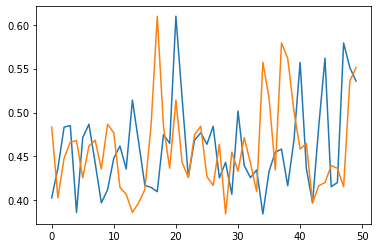

In [59]:
plt.plot(abs(pd.Series(combined.sort_values(kind="quicksort", ascending=True, by='ZCAs',key=abs)['Anomaly'])).reset_index(drop=True))
plt.plot(abs(pd.Series(combined.sort_values(kind="quicksort", ascending=True, by='mdist',key=abs)['Anomaly'])).reset_index(drop=True))
plt.show()

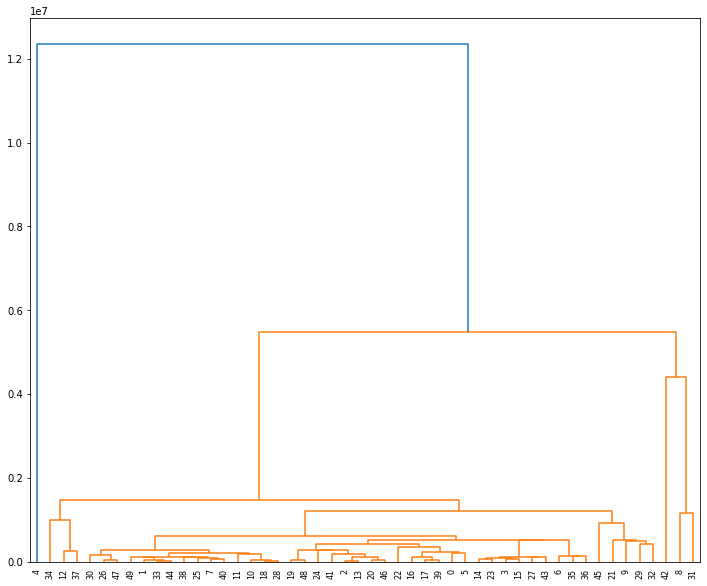

In [265]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(1, 2, )

ytdist = df2[a[1:]]
Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(12, 10))
dn = hierarchy.dendrogram(Z)

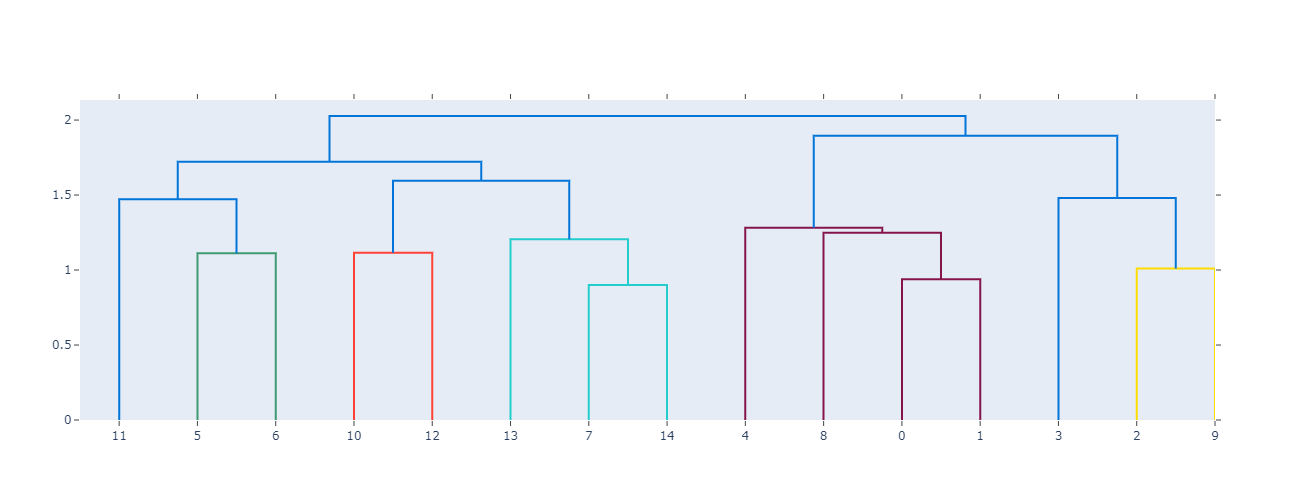

In [247]:
rules

['if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White <= 238.35) and (Poverty <= 94.05) and (Poverty > 89.05) and (Crime <= 2.125) then response: 0.468 | based on 3 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White > 238.35) and (States <= 6.35) and (University <= 53728.5) and (Unemployed > 1542247.0) then response: 0.414 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White > 238.35) and (States <= 6.35) and (University <= 53728.5) and (Unemployed <= 1542247.0) then response: 0.431 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty <= 84.15) and (Crime <= 1.65) and (White <= 252.5

In [217]:
import imgkit

def highlight_greaterthan(x):
    if abs(x['Anomaly']) >= .6:
        return ['background-color: purple']*12
    elif abs(x['Anomaly']) >= .55:
        return ['background-color: red']*12
    elif abs(x['Anomaly']) >= .5:
        return ['background-color: yellow']*12
    else:
        return ['background-color: white']*12

html = df2.style.apply(highlight_greaterthan, axis=1).set_precision(2).render()

imgkit.from_string(html, 'state_anomalies.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

<AxesSubplot:>

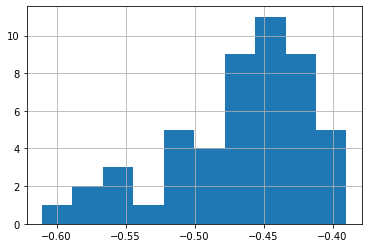

In [132]:
df2["Anomaly"].hist()